<a href="https://colab.research.google.com/github/DanieleAngioni97/ML_Project/blob/master/Autoencoders_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

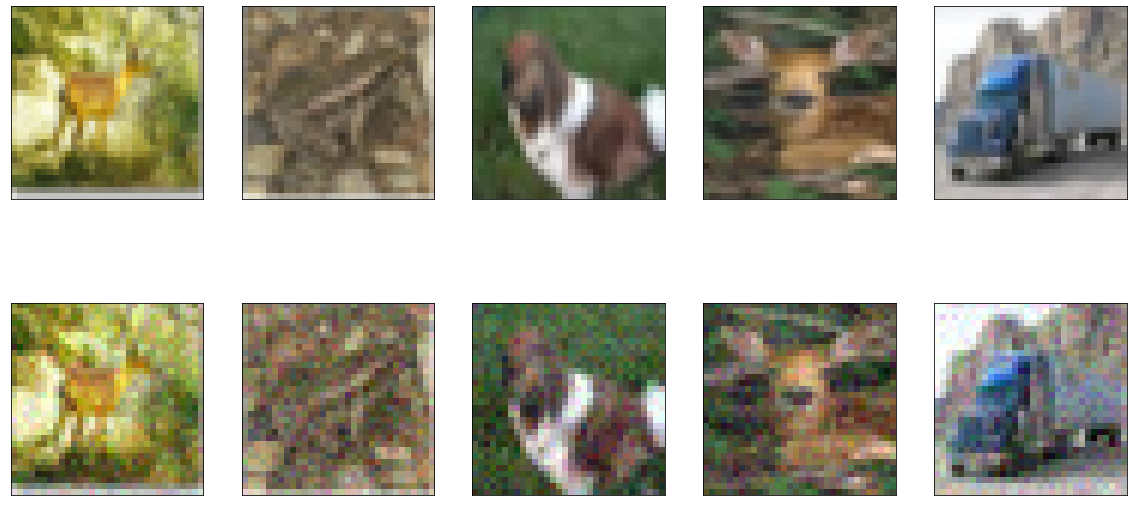

In [ ]:
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
 
(x_train, _), (x_test, _) = cifar10.load_data()
 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format
 
noise_factor = 0.05
#loc and scale being mean and std
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
 
#clip pixel under 0 and above 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
 
n = 5
bias = 500
plt.figure(figsize=(20, 10))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i+bias].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    ax = plt.subplot(2, n, n+i+1)
    plt.imshow(x_test_noisy[i+bias].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
from keras.layers import Input, Conv2D, AveragePooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
 
 
def create_autoencoder():
        
    input_img = Input(shape=(32, 32, 3))  # adapt this if using `channels_first` image data format
 
    #-------------------------------------------------------------------------------
    #-------------------------------------------------------------------------------
    #                       DEFINE AUTOENCODER ARCHITECTURE
    #-------------------------------------------------------------------------------
    #-------------------------------------------------------------------------------
 
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x) #16x16
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x)   #8x8
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x)   #4x4
    encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
 
    # at this point the representation is (4, 4, 128)
 
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x) #8x8
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x) #16x16
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x) #32x32
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
 
    autoencoder = Model(input_img, decoded)
    
    # Display the model's architecture
    #autoencoder.summary()
 
    return autoencoder

In [ ]:
pretrained = True   #Set this if you want to start training from a pretrained autoencoder
pretrained_autoencoder = "autoencoderCifar8.h5"
 
 
autoencoder = create_autoencoder()  #create the architecture
 
if pretrained == True:
    autoencoder.load_weights(pretrained_autoencoder)
 
optim = Adam(learning_rate=0.001)
loss = MeanSquaredError()
autoencoder.compile(optimizer=optim, loss=loss)
 
 
n_epochs = 50
save_step = 2
 
for i in range(n_epochs):    
    print("\n%%-------EPOCH # {} --------%%".format(i))    
    autoencoder.fit(x_train_noisy, x_train,
                    epochs=1,
                    batch_size=128,
                    shuffle=True,
                    verbose=1,
                    validation_data=(x_test_noisy, x_test))
    if i%save_step == 0:
        autoencoder.save_weights("autoencoderCifar" + str(i) + ".h5")

# **Training Diary (real epochs are i+1)**
epoch 98 -> loss = 0.0015 - val_loss = 0.0015

epoch 8 -> loss: 0.0015 - val_loss: 0.0014



# **Start here if you only want to evaluate the pretrained model**

In [ ]:
from keras.models import load_model
 
autoencoder = create_autoencoder()
autoencoder.load_weights("autoencoderCifar8.h5")

OSError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


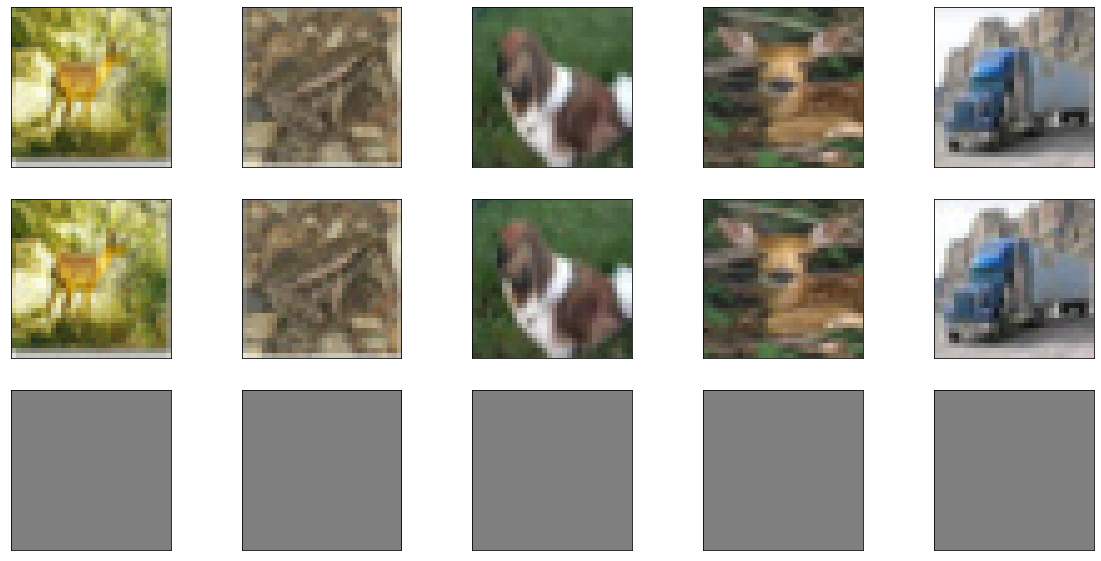

In [ ]:
n = 5
bias = 500
plt.figure(figsize=(20, 10))
 
x_test_noisy = x_test + 0.01 * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
decoded_imgs = autoencoder.predict(x_test_noisy)
 
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i+bias].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    # display corrupted
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i+bias].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i+bias].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()